In [1]:
import pandas as pd 
import numpy as np 
import statsmodels.api as sm 
from statsmodels.api import (add_constant,OLS, Logit)


In [2]:
from math import exp
from sklearn.linear_model import LassoCV
from sklearn.model_selection import (KFold,train_test_split,cross_val_score, StratifiedKFold)
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
 

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import warnings 
warnings.simplefilter("ignore")

In [5]:
hotel_cancel = pd.read_csv("hotel_cancellation.csv")

## Question 1

In [6]:
hotel_cancel = hotel_cancel.iloc[:,1:].copy()

###### Understand the distribution of room assignmet and cancellation 

In [7]:
round(pd.crosstab(hotel_cancel.different_room_assigned, hotel_cancel.is_canceled, normalize= True)*100,2)

is_canceled,False,True
different_room_assigned,,
False,50.62,38.47
True,10.35,0.56


Clearly, only 0.56 % of all reservations are cancelled if a different room is assigned. Which is interesting, are the room that are available via bookings websites bad? Do they have to change the room to a different room later based on avalability?

In [8]:
hotel_cancel.different_room_assigned = hotel_cancel.different_room_assigned.astype(int)
hotel_cancel.is_canceled = hotel_cancel.is_canceled.astype(int)


In [9]:
x = hotel_cancel.iloc[:, :-1]
y = hotel_cancel.iloc[:, -1]

In [10]:
x_vars = add_constant(x, has_constant= "add")

In [11]:
model = Logit(y, x_vars).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.597308
         Iterations 18
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:               102894
Model:                          Logit   Df Residuals:                   102887
Method:                           MLE   Df Model:                            6
Date:                Tue, 14 Feb 2023   Pseudo R-squ.:                  0.1070
Time:                        19:19:28   Log-Likelihood:                -61459.
converged:                       True   LL-Null:                       -68825.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       356.5464     23.369     15.257      0.000     310

In [12]:
# parameters = model.params.a|pply(lambda x : exp(x)).iloc[1:]
parameters = model.params
round(parameters,2)

const                        356.55
lead_time                      0.01
arrival_date_year             -0.18
arrival_date_week_number      -0.01
arrival_date_day_of_month     -0.00
days_in_waiting_list           0.00
different_room_assigned       -2.55
dtype: float64

The above model suggests that assigning a different room reduces the logg odds of cancellation by 2.55 on an average all else equal. 

For every unit increase in lead time, the log odd ratio of cancellation goes up by 0.01 accounting for all other varables.

Every year the log odds of cancellation will go down by .18 on an average accounting for all other factors.

The log odds of cancellation will go down by 0.01 every week on an average accounting for all the other factors.

Arrival_day_of_month and days_in_waiting_list have little to no impact on odds ratio all else equal. 

## Question 2 

In [13]:

def run_logit1(y,x):
    """
    Run the first logistic model 
    y : Dependant Variable (Pandas Series)
    x : Independant Variables (Pandas DataFrame)
    """
    
    y = x.different_room_assigned
    x = x.iloc[:, :-1]
    
    model = Logit(y,x).fit()
#     print(model.summary())
    
    
    return model
    
def run_logit2(y,y_hat,x):
    """
    Run the second logistic model 
    y : Dependant Variable (Pandas Series)
    y_hat : y_hat from the first login (numpy array)
    x : Independant Variables (Pandas DataFrame)
    """
    x = pd.concat([x,pd.Series(y_hat,name='d_hat')],  axis=1)
    model = Logit(y,x).fit()
#     print(model.summary())
    return model

    
logit1_model = run_logit1(y,x_vars)
y_hat = logit1_model.predict()

Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 17


In [14]:
print(logit1_model.summary())

                              Logit Regression Results                             
Dep. Variable:     different_room_assigned   No. Observations:               102894
Model:                               Logit   Df Residuals:                   102888
Method:                                MLE   Df Model:                            5
Date:                     Tue, 14 Feb 2023   Pseudo R-squ.:                 0.04219
Time:                             19:19:29   Log-Likelihood:                -33955.
converged:                            True   LL-Null:                       -35450.
Covariance Type:                 nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      1033.8356     35.098     29.456      0.000     965.045    1102.626
lead_time                    -0.0048      0.00

In [15]:
logit2_model = run_logit2(y,y_hat, x_vars)

         Current function value: 0.592949
         Iterations: 35


In [16]:
print(logit2_model.summary2())

                                 Results: Logit
Model:                    Logit                Pseudo R-squared:     0.114      
Dependent Variable:       is_canceled          AIC:                  122037.8795
Date:                     2023-02-14 19:19     BIC:                  122114.2111
No. Observations:         102894               Log-Likelihood:       -61011.    
Df Model:                 7                    LL-Null:              -68825.    
Df Residuals:             102886               LLR p-value:          0.0000     
Converged:                0.0000               Scale:                1.0000     
No. Iterations:           35.0000                                               
--------------------------------------------------------------------------------
                            Coef.   Std.Err.    z     P>|z|    [0.025    0.975] 
--------------------------------------------------------------------------------
const                     1716.0527  50.7098  33.8407 0.0000 

In [17]:
# parameters = logit2_model.params.apply(lambda x : exp(x)).iloc[1:]
parameters = logit2_model.params
round(parameters,2)

const                        1716.05
lead_time                       0.00
arrival_date_year              -0.85
arrival_date_week_number       -0.02
arrival_date_day_of_month      -0.00
days_in_waiting_list            0.00
different_room_assigned        -2.54
d_hat                         -14.19
dtype: float64

The model seems significant with all the p-values way below the significance level

The above model suggests that assigning a different room reduces the log odds of cancellation by 2.54 on an average all else equal. 

Every year the log odds of cancellation will go down by .85 on an average accounting for all other factors. 

The log odds of cancellation will go down by .02 every week on an average accounting for all the other factors. 

Lead_time, Arrival_day_of_month and days_in_waiting_list have little to no impact on odds ratio all else equal. 

## Question 3 

In [18]:
room_assigned = []

def double_logit(y,x):
    """
    Logs the odds for different_room_assigned for each boot
    y : bootstrapped y variable 
    x : bootstrapped x variable
    """
    
    model_1 = run_logit1(y,x)
    y_hat = model_1.predict()
    model = run_logit2(y,y_hat,x)
    odds_room_assigned = model.params.different_room_assigned
    room_assigned.append(odds_room_assigned)
    

n = 1000

for _ in range(n):
    x_boot, y_boot = resample(x_vars, y, replace=True)
    x_boot.reset_index(inplace = True, drop = True)
    y_boot=y_boot.reset_index(drop = True,)
    double_logit(y_boot,x_boot)
    

Optimization terminated successfully.
         Current function value: 0.332179
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593458
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.330835
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.591860
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.328380
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.595219
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.332110
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.591601
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.331474
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592042
  

Optimization terminated successfully.
         Current function value: 0.592360
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.332793
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593770
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.329584
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.594278
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.329881
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.591854
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.330870
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593301
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.331133
  

Optimization terminated successfully.
         Current function value: 0.591592
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.328139
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593506
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.327200
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.595178
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.328513
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.593470
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.331050
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.594824
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.332809

Optimization terminated successfully.
         Current function value: 0.590936
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.330720
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.594092
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.331084
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.595572
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.327943
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.591545
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.332410
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.594435
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.330483
 

Optimization terminated successfully.
         Current function value: 0.327334
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592964
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.325933
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593196
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.329389
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593406
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.328059
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593088
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.328982
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593153
  

Optimization terminated successfully.
         Current function value: 0.594025
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.327519
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.594458
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.330371
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.591293
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.329972
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592739
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.329975
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.592573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.326391


Optimization terminated successfully.
         Current function value: 0.593809
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.327991
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.594831
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.332959
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.591312
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.329325
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593919
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.327187
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592673
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.329346
  

Optimization terminated successfully.
         Current function value: 0.329386
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.591556
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.326588
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.594301
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.332360
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593571
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.328257
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592843
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.327910
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.591977
  

Optimization terminated successfully.
         Current function value: 0.591350
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.327001
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.594409
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.327632
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592469
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.328337
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.591919
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.329940
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.591573
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.329786
 

Optimization terminated successfully.
         Current function value: 0.327546
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592970
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.331279
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.590498
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.330362
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.591994
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.329687
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.595878
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.331302
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.590941
  

Optimization terminated successfully.
         Current function value: 0.594200
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.331845
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.594233
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.332695
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593336
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.331929
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.592917
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.329251
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593726
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.331868
  

Optimization terminated successfully.
         Current function value: 0.332055
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593764
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.329825
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592049
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.330495
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592876
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.330574
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.593682
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.328522
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.592353
  

Optimization terminated successfully.
         Current function value: 0.331811
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.591900
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.328996
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593145
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.331909
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.591888
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.330421
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.594280
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.330777
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.591033
 

Optimization terminated successfully.
         Current function value: 0.593034
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.332337
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593190
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.332637
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.592544
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.332740
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.593369
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.331947
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.593172
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.329903
 

Optimization terminated successfully.
         Current function value: 0.594373
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.330957
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592121
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.327836
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.594038
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.329740
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592743
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.330636
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.591422
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.328668
 

Optimization terminated successfully.
         Current function value: 0.592368
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.329042
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593881
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334263
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.592509
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.329574
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.593249
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.332856
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593185
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.327281
 

Optimization terminated successfully.
         Current function value: 0.330588
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593767
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.331210
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593889
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.328732
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592255
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.332235
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.591585
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.333264
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.592640
  

Optimization terminated successfully.
         Current function value: 0.589913
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.328373
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.594349
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.330361
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.595314
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.329752
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.591866
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.333160
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.592694
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.330519
 

Optimization terminated successfully.
         Current function value: 0.593227
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.330155
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.594144
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.330076
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592581
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.330599
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.591658
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.328117
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.591735
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.332022
  

Optimization terminated successfully.
         Current function value: 0.592471
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.326993
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593678
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.329862
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592701
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.332774
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.592239
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.331189
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592736
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.328409


Optimization terminated successfully.
         Current function value: 0.329668
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.593707
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.331122
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.593785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.328763
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593054
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.332486
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592516
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.329170
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593349
  

Optimization terminated successfully.
         Current function value: 0.591413
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.331150
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593316
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.328941
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.594932
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.330908
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592230
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.330756
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592388
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.329484
  

         Current function value: 0.334741
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593152
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.329715
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592574
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334072
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.591291
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.331556
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.591183
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.331340
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.594528
         Iterations 9
Optimization term

Optimization terminated successfully.
         Current function value: 0.590522
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.328482
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592805
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.329570
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592526
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.331669
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592036
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.327431
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.594018
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.330920
 

Optimization terminated successfully.
         Current function value: 0.330166
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.591670
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.330049
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.592683
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.325485
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.594108
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.330949
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.593946
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.332204
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593095
  

In [19]:
median = np.percentile(room_assigned, 50)

# get 95% interval
alpha = 100-95
lower_ci = np.percentile(room_assigned, alpha/2)
upper_ci = np.percentile(room_assigned, 100-alpha/2)
sd = np.std(room_assigned)

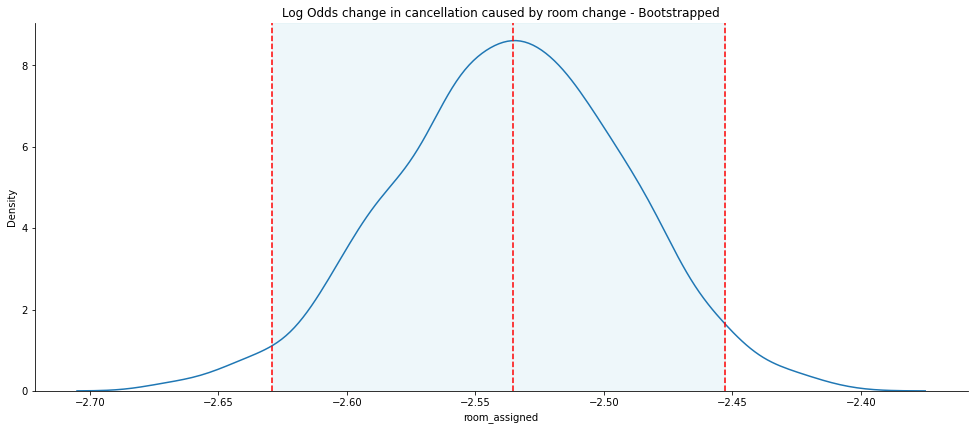

In [21]:
ax = sns.displot(data = pd.DataFrame(room_assigned, columns=['room_assigned']), 
            x="room_assigned", kind="kde")
ax.fig.set_figwidth(15)
ax.fig.set_figheight(6)
plt.title("Log Odds change in cancellation caused by room change - Bootstrapped")
plt.xlabel("room_assigned")
plt.axvline(median,0, 1, linestyle="--", color="red")
plt.axvline(lower_ci,0, 1, linestyle="--", color="red")
plt.axvline(upper_ci,0, 1, linestyle="--", color="red")
plt.axvspan(lower_ci, upper_ci, alpha=0.2, color='lightblue')
plt.show()

In [22]:
print(f"The 95 % confidance interval for treatment effect (Log odds) is {round(lower_ci,2)} and {round(upper_ci,2)}. The standard error is {round(sd,3)}")

The 95 % confidance interval for treatment effect (Log odds) is -2.63 and -2.45. The standard error is 0.045


## Question 4

In [23]:
drinking_df = pd.read_csv("drinking.csv")

In [24]:
th_age = 21

In [25]:
drinking_df.head()

,age,others,accident,suicide
0,19.068493,92.825401,35.829327,11.203714
1,19.150684,95.100739,35.639256,12.193368
2,19.232876,92.144295,34.205650,11.715812
3,19.315069,88.427757,32.278957,11.275010
4,19.397261,88.704941,32.650967,10.984314


In [26]:
age_2021 = drinking_df.age.between(20,21)
age_2122 = (drinking_df.age > 21) & (drinking_df.age <= 22)

mean_age_2021 = drinking_df.loc[age_2021].mean()
mean_age_2122 = drinking_df.loc[age_2122].mean()

rdd_df = pd.concat([pd.DataFrame(mean_age_2021, columns=['20_21']),
           pd.DataFrame(mean_age_2122, columns=['21_22'])], axis = 1)

In [27]:
age_less21 = drinking_df.age < 21
age_more21 = drinking_df.age >= 21

mean_age_less21 = drinking_df.loc[age_less21].mean()
mean_age_more22 = drinking_df.loc[age_more21].mean()

base_age_df = pd.concat([pd.DataFrame(mean_age_less21, columns=['less_21']),
           pd.DataFrame(mean_age_more22, columns=['more_21'])], axis = 1)

In [28]:
rdd_df_final = pd.concat([base_age_df,rdd_df],axis =1) 

In [29]:
def plot_rdd(col_name):
    fig, ax = plt.subplots(figsize = (18,8))

    sns.scatterplot(x= 'age', y= col_name, data=drinking_df, label='21 or Younger')
    sns.regplot(x= "age", y= col_name,data=drinking_df.loc[age_2021], color="red")
    sns.regplot(x= "age", y= col_name,data=drinking_df.loc[age_2122], color= "grey")
    plt.axvline(x=20, color='green', linestyle='--')
    plt.axvline(x=22, color='green', linestyle='--')
    plt.legend(["Non-RDD","Age 20-21","Reg. line 20-21","CI - 20-21","Age 21-22","Reg. line 21-22","CI - 21-22"])
    plt.xlabel('Age')
    plt.ylabel(f'% of deaths by {col_name}')
    plt.title(f"Deaths by {col_name} vs Age");


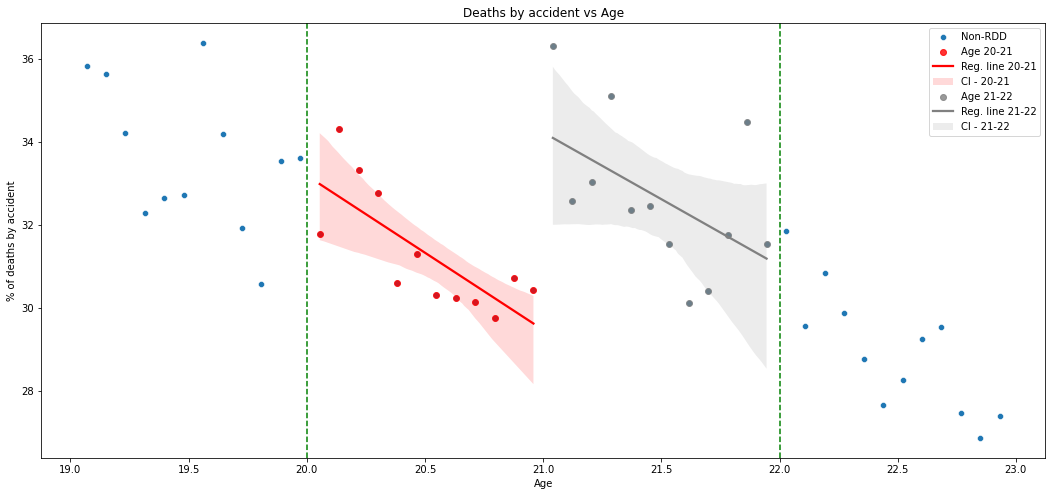

In [30]:
plot_rdd("accident")

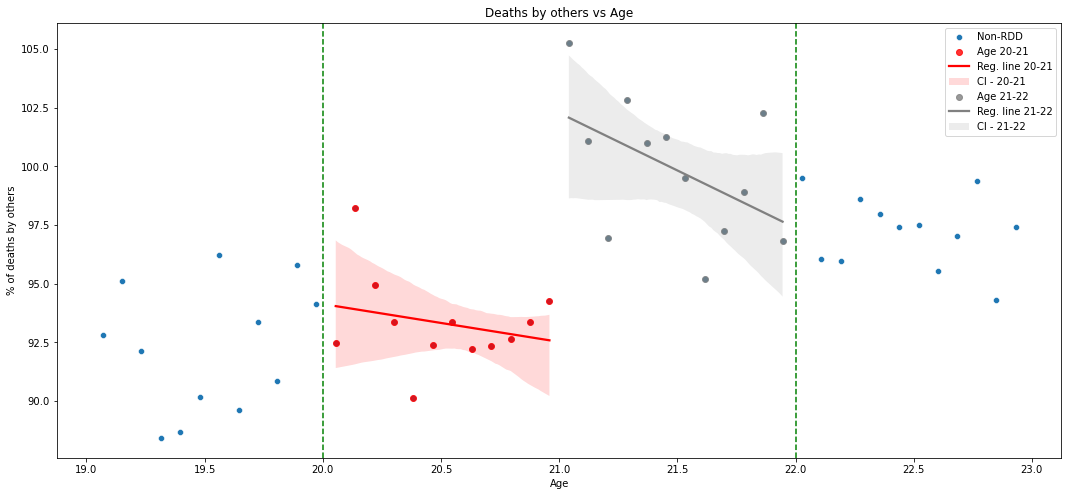

In [31]:
plot_rdd("others")

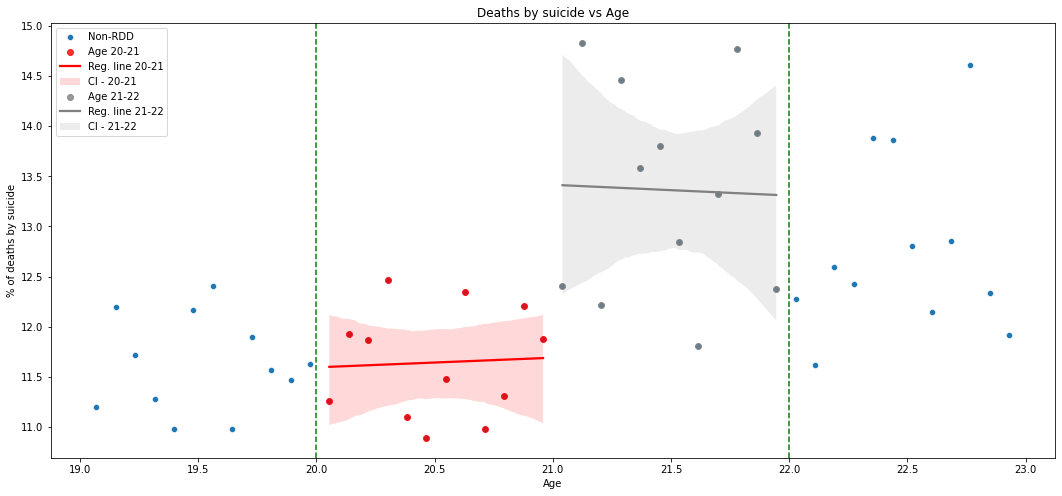

In [32]:
plot_rdd("suicide")

In [33]:
rdd_df_final['treatment'] =  rdd_df_final['21_22'] - rdd_df_final['20_21']

In [34]:
rdd_df_final

,less_21,more_21,20_21,21_22,treatment
age,20.053150,21.946849,20.577299,21.493151,0.915852
others,92.802702,98.542747,93.318850,99.860510,6.541660
accident,32.461662,30.784306,31.296563,32.635049,1.338486
suicide,11.633759,13.070201,11.642920,13.361998,1.719078


#### Should the legal age for drinking be reduced from 21?

#### Results are untrustworthy 

These results are interesting :)

Assuming the data are not randomly created for the question's sake, Let's try to understand each of these differences and reason with the causal effects of alcohol.

Accidents: - 
The treatment effect of 1.34 suggests that drinking causes a higher death rate. But even if we increase the legal age to 23 or 25, I believe we would see a similar increase in the death rate - assuming we accounted for all other confounding variables. 

We have strict laws for driving under the influence -> It takes time to getting used to new rules.  

Other deaths:- 
We dont know what these other deaths are, but it looks like they follow a similar trend to Accidents. So even though there is a treatment effect of 6.54, without knowing the exact cause, data seems to have no confounding variables. 

Suicides: - 
We do not know the reason for suicides. 
It is difficult to answer these questions with the data provided - 

Does alcohol induce suicide? Does alcohol prevent suicide in some cases? Does alcohol-related misconduct increase the risk of suicide? Do people drink to ensure the courage to engage in their suicidal acts? Is alcohol part of the method for the suicidal act?

Issues with causality with RDD: -  we dont know if 21 is an age limit for anything else - > we have a clear confounder so in such cases we can't use RDD and infer causality  



#### What might be the effect of choosing a smaller bandwidth?
#### What if we chose the maximum bandwidth?

A smaller bandwidth will give accurate results, given enough data points. However, if data sparsity exists, we can not confidently conclude the causality. 

If we choose maximum bandwidth, we will have to factor in all the confounding variables before making causal inferences. The RDD wil result in a simple comparition between means for the two groups - which is biased and not causal 

## Question 5

In [35]:
iris_df = pd.read_csv("iris.csv")

In [36]:
iris_df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [37]:
x_vars = iris_df.iloc[:,:-1]
y = iris_df.variety

In [38]:
def run_one_knn(K, x_vars, y,rs):
    """
    Runs the KNN model 
    K - folds
    x_vars - x_vars 
    y - Variety
    rs - randomstate
    """
    scores_dict = {}
    X_train, X_test, y_train, y_test = train_test_split(x_vars, y, test_size=0.3, random_state=rs, stratify=y)
    knn = KNeighborsClassifier(n_neighbors=K,p=1)
    knn.fit(X_train,y_train)
    
    scores_dict[K] = knn.score(X_test,y_test)
    return scores_dict

In [39]:
score_out = []
for K in [1, 3, 5, 7]:
    score_out.append(run_one_knn(K,x_vars,y,34))

In [40]:
score_out

[{1: 0.9333333333333333},
 {3: 0.9555555555555556},
 {5: 0.9555555555555556},
 {7: 0.9333333333333333}]

In [41]:
score_out = []
for K in [1, 3, 5, 7]:
    score_out.append(run_one_knn(K,x_vars,y,8))

In [42]:
score_out

[{1: 0.8666666666666667},
 {3: 0.9111111111111111},
 {5: 0.9111111111111111},
 {7: 0.9333333333333333}]

##### The output is dependent on the seed, We should consider doing CV 

In [43]:
def run_knn_cv(K,X, y, dist_metric = "minkowski"):
    """
    Returns mean score from KNN CV
    K - Number of folds
    X - x varialbles 
    y - variety
    """
    knn_cv = KNeighborsClassifier(n_neighbors=K,p=1,metric=dist_metric) 
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=96)
    cv_scores = cross_val_score(knn_cv, X, y, cv=cv, scoring="accuracy")
    print(dist_metric,K, cv_scores)    
    return np.mean(cv_scores)

In [44]:
def get_scores(metric_name):
    score_out = []
    for K in [1, 3, 5, 7]:
        score_out.append(run_knn_cv(K, x_vars, y,metric_name))
    return score_out

mink_score = get_scores("minkowski")
euc_score = get_scores("euclidean")
man_score = get_scores("manhattan")
che_score = get_scores("chebyshev")

minkowski 1 [0.96 0.96 0.94]
minkowski 3 [0.98 0.96 0.96]
minkowski 5 [0.94 0.98 0.96]
minkowski 7 [0.98 0.96 0.96]
euclidean 1 [0.98 0.96 0.94]
euclidean 3 [0.98 0.96 0.98]
euclidean 5 [0.96 0.98 0.98]
euclidean 7 [0.98 0.96 0.98]
manhattan 1 [0.96 0.96 0.94]
manhattan 3 [0.98 0.96 0.96]
manhattan 5 [0.94 0.98 0.96]
manhattan 7 [0.98 0.96 0.96]
chebyshev 1 [0.98 0.94 0.94]
chebyshev 3 [0.98 0.94 0.96]
chebyshev 5 [0.98 0.96 0.92]
chebyshev 7 [0.98 0.98 0.92]


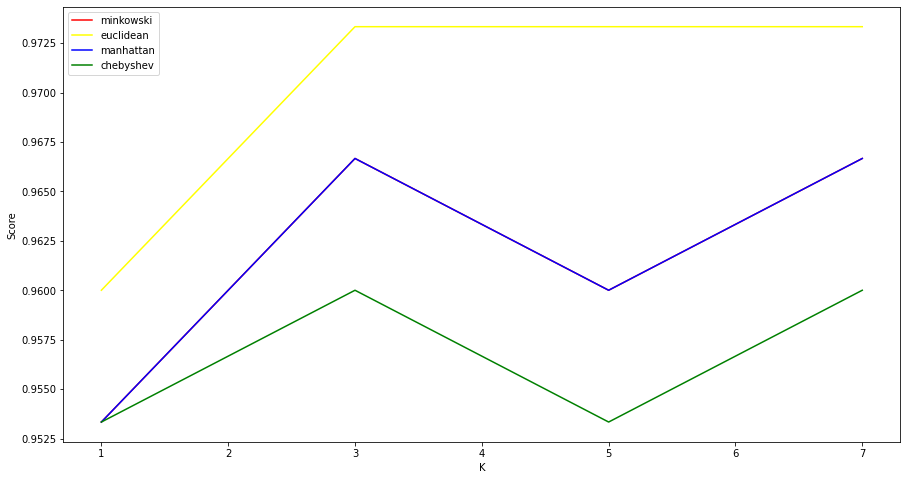

In [45]:
plt.figure(figsize=(15,8))
sns.lineplot(data=pd.DataFrame({"K":[1,3,5,7],"Score":mink_score}), x="K", y="Score", color = "red", label='minkowski')
sns.lineplot(data=pd.DataFrame({"K":[1,3,5,7],"Score":euc_score}), x="K", y="Score", color = "yellow", label='euclidean')
sns.lineplot(data=pd.DataFrame({"K":[1,3,5,7],"Score":man_score}), x="K", y="Score",color = "blue", label = "manhattan")
sns.lineplot(data=pd.DataFrame({"K":[1,3,5,7],"Score":che_score}), x="K", y="Score", color = "green", label = "chebyshev")

plt.legend();

K = 3 and 7 seem to have the highest scores. We can choose 3 to factor in the underfitting and higher computational needs as k increases. 

However, the outcome of the model seems to be completely based on the seed provided.

###### Which distance/similarity metric did you choose to use and why?

I would choose Euclidean, clearly it outperforms the rest of the distance metrics. Euclidean distance works best for normally distributed data